In [5]:
import sys

In [6]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.23.1
!{sys.executable} -m pip install pygame

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
# from gym.envs.toy_text.frozen_lake import generate_random_map


In [53]:
def trainModel(env, num_episodes, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_factor=5, linear_exploration=False):

    max_steps_per_episode = 400

    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    exploration_rate = max_exploration_rate
    exploration_decay_rate = (
        max_exploration_rate - min_exploration_rate) / num_episodes
    rewards_all_episodes = []

    # Q-Learning algorithm
    for episode in range(num_episodes):

        # random_map = generate_random_map(size=4, p=0.8)
        # env = gym.make("FrozenLake-v0", desc=random_map)
        state = env.reset()

        done = False
        rewards_current_episode = 0

        for step in range(max_steps_per_episode):

            # Exploration / Exploitation trade-off
            exploration_rate_threshold = random.uniform(0, 1)
            if exploration_rate_threshold > exploration_rate:
                action = np.argmax(q_table[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)

            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate *
                                 np.max(q_table[new_state, :]))

            state = new_state
            rewards_current_episode += reward

            if done == True:
                break

        # Exploration rate decay
        if linear_exploration:
            exploration_rate -= exploration_decay_rate
        else:
            exploration_rate = min_exploration_rate + \
                (max_exploration_rate - min_exploration_rate) * \
                np.exp(-exploration_decay_rate *
                       episode*exploration_decay_factor)

        rewards_all_episodes.append(rewards_current_episode)
    return rewards_all_episodes


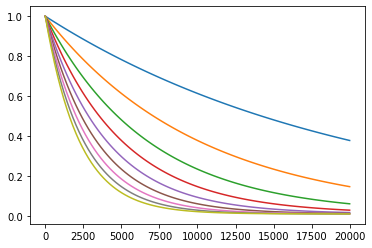

In [9]:
def explorationDecayRate(episodes,max,min,factor):
  decay_rate = (max-min)/episodes
  x = np.linspace(0,episodes,num=100)
  y = min+(max-min)*np.exp(-decay_rate*factor*x)
  plt.plot(x,y)

for i in range(1,10):
  explorationDecayRate(20000,1,0.01,i)

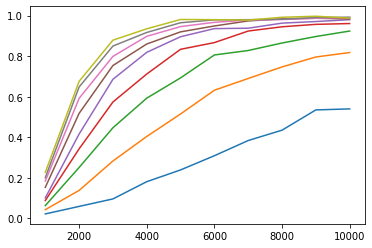

In [55]:

env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
num_episodes = 10000
n = 1000

for i in range(1, 10):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.95, max_exploration_rate=1, min_exploration_rate=0.01, exploration_decay_factor=i)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y)


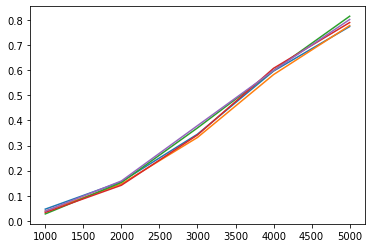

In [57]:
num_episodes = 5000
n = 1000

for i in range(5):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.95, max_exploration_rate=1, min_exploration_rate=0.1, linear_exploration=True)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y)


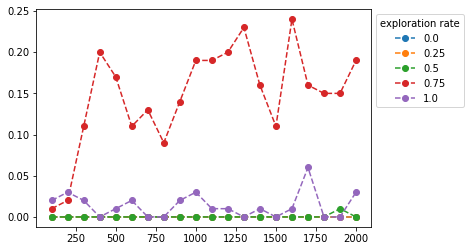

In [60]:
num_episodes = 2000
n = 100

for i in np.linspace(0,1,num=5):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.95, max_exploration_rate=i, min_exploration_rate=i, linear_exploration=True)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y,'o--', label=i)
    plt.legend(title="exploration rate", bbox_to_anchor=(1,1))


In [87]:
num_episodes = 1000



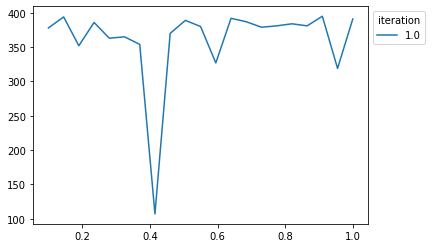

In [63]:
num_episodes=1000
n = 100

for _ in range(1):
    x = []
    y = []
    for i in np.linspace(0.1, 1, num=21):
        rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=i,
                                          discount_rate=0.95, max_exploration_rate=1, min_exploration_rate=0.1, linear_exploration=True)
        rewards_per_n_episodes = np.split(
            np.array(rewards_all_episodes), num_episodes / n)
        x1 = (np.arange(num_episodes / n)+1)*n
        y1 = np.sum(rewards_per_n_episodes, 1)/n
        # plt.plot(x, y)
        x.append(i)
        y.append(np.sum(rewards_all_episodes))

    plt.plot(x, y, label=i)
    plt.legend(title="iteration", bbox_to_anchor=(1,1))

In [36]:
# random_map = generate_random_map(size=4, p=0.8)
# env = gym.make("FrozenLake-v0", desc=random_map)
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
for episode in range(1):
    state = env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)

    for step in range(max_steps_per_episode):        
        clear_output(wait=True)
        env.render()
        time.sleep(0.3)
        
        action = np.argmax(q_table[state,:])        
        new_state, reward, done, info = env.step(action)
        
        if done:
            clear_output(wait=True)
            env.render()
            if reward == 1:
                print("****You reached the goal!****")
                time.sleep(3)
            else:
                print("****You fell through a hole!****")
                time.sleep(3)
            clear_output(wait=True)
            break
            
        state = new_state
        
env.close()

****You reached the goal!****


: 